In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

    # load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [3]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [5]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, Flatten,
    BatchNormalization, Activation,
    Add, GlobalAveragePooling1D, MaxPooling1D,
    LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# TensorFlow ResNet 블록 정의
def resnet_block(inputs, filters):
    x = Conv1D(filters, kernel_size=3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv1D(filters, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters, kernel_size=1, padding="same")(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# Transformer 블록 정의
def transformer_block(inputs, num_heads=4, ff_dim=128):
    x = LayerNormalization()(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x, x)
    x = Add()([x, attn_output])

    x = LayerNormalization()(x)
    ff_output = Dense(ff_dim, activation="relu")(x)
    ff_output = Dense(inputs.shape[-1])(ff_output)

    x = Add()([x, ff_output])
    return x

def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # ResNet Blocks
    x = resnet_block(inputs, 64)
    x = MaxPooling1D(pool_size=2)(x)
    x = resnet_block(x, 128)
    x = MaxPooling1D(pool_size=2)(x)

    # Transformer Encoder
    x = transformer_block(inputs)
    x = GlobalAveragePooling1D()(x)

    # Fully Connected Layers
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_outputs, activation="softmax")(x)  # 3개의 클래스

    model = Model(inputs, outputs)
    return model

model = build_model(input_shape=(n_timesteps,n_features))
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
history = model.fit(x=X_train, y=y_train_one_hot, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4168 - loss: 1.3667 - val_accuracy: 0.8421 - val_loss: 0.4348
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8101 - loss: 0.4866 - val_accuracy: 0.9100 - val_loss: 0.2305
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8952 - loss: 0.2863 - val_accuracy: 0.9389 - val_loss: 0.1614
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9215 - loss: 0.2104 - val_accuracy: 0.9457 - val_loss: 0.1316
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9374 - loss: 0.1677 - val_accuracy: 0.9474 - val_loss: 0.1171
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9376 - loss: 0.1590 - val_accuracy: 0.9525 - val_loss: 0.1091
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9437 - loss: 0.1367 - val_accuracy: 0.9559 - val_loss: 0.1098
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9445 - loss: 0.1313 - val_accuracy: 

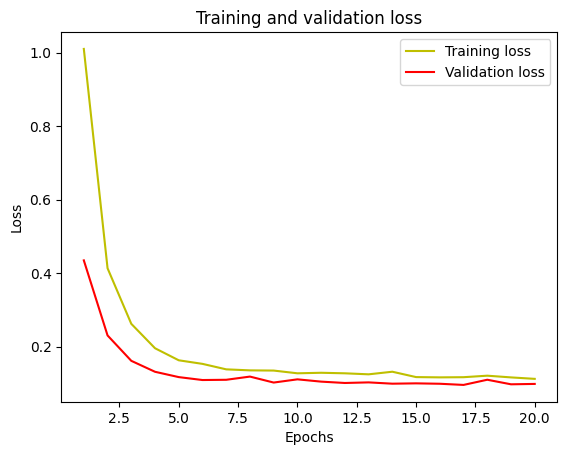

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

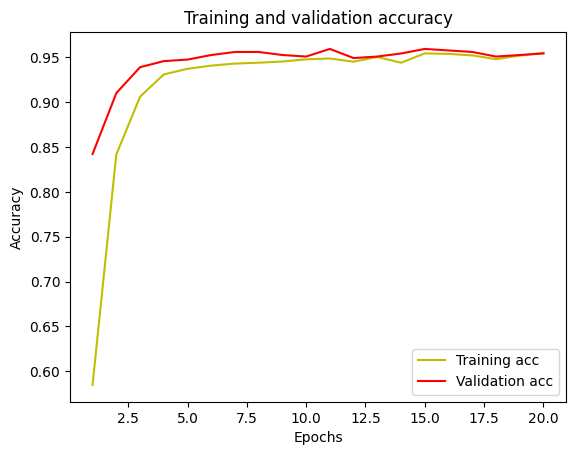

In [11]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
[[417  17  62   0   0   0]
 [ 17 414  40   0   0   0]
 [  4  11 405   0   0   0]
 [  0  19   0 395  72   5]
 [  0   1   0  82 449   0]
 [  0   0   0   0   0 537]]
0.8880217170003394
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       496
           1       0.90      0.88      0.89       471
           2       0.80      0.96      0.87       420
           3       0.83      0.80      0.82       491
           4       0.86      0.84      0.85       532
           5       0.99      1.00      1.00       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

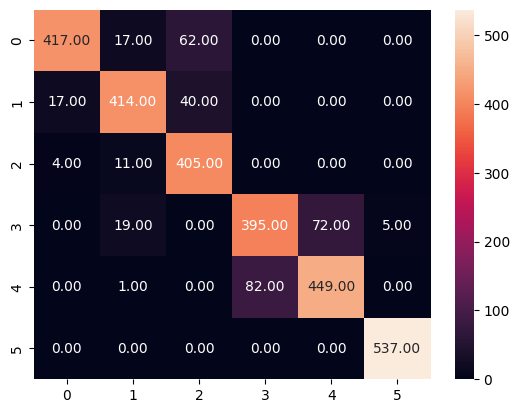

In [12]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')